# 📘 Exploratory Data Analysis (EDA) — NSW Operational Demand (2024)

This notebook performs a full Exploratory Data Analysis (EDA) on **NSW electricity demand** using AEMO DISPATCHREGIONSUM data. The data is retrieved from a MongoDB instance and covers the calendar year 2024.

The primary goal is to understand **daily, weekly, monthly, hourly, and seasonal demand patterns**, which form the necessary foundation for accurate load forecasting and case-study insights.

---

### 📑 Table of Contents

| Section | Steps | Purpose |
| :--- | :--- | :--- |
| **1️⃣ Data Loading & Pre-Processing** | 1.1 Connect to MongoDB | Ensure the dataset is accurate, consistent, and ready for analysis. |
| | 1.2 Load NSW (2024) operational demand data | |
| | 1.3 Convert timestamp fields (SETTLEMENTDATE → datetime) | |
| | 1.4 Extract time features (hour, day, weekday, month, season) | |
| | 1.5 Check for missing & duplicated values | |
| | 1.6 Data consistency check (5-minute interval verification) | |
| **2️⃣ Understanding Demand Distributions** | 2.1 Summary statistics (mean, median, min/max, percentiles) | Establish statistical boundaries and detect anomalies. |
| | 2.2 Distribution of TOTALDEMAND | |
| | 2.3 Outlier inspection (if any) | |
| **3️⃣ Daily / Weekly / Seasonal Patterns** | 3.1 Average hourly demand (24-hour profile) | Identify regular, recurring behavioural load cycles. |
| | 3.2 Average weekly demand (Mon–Sun comparison) | |
| | 3.3 Monthly or seasonal variations | |
| | 3.4 Detecting intra-day on/off-peak patterns | |
| **4️⃣ Trend Analysis** | 4.1 Daily average demand | Smooth out noise to reveal underlying long-term movement. |
| | 4.2 7-day rolling average | |
| | 4.3 30-day rolling average | |
| | 4.4 Identifying long-term seasonal behaviour | |
| **5️⃣ Heatmap Analysis** | 5.1 Hour-of-day × Month heatmap | Identify critical periods where daily and seasonal peaks coincide. |
| | 5.2 Interpretation of morning peaks, evening peaks, and solar dips | |
| | 5.3 Seasonal intensity identification (summer vs winter) | |
| **6️⃣ Insights & Summary** | 6.1 Key findings from EDA | Consolidate learning and interpret results in a business context. |
| | 6.2 What this means for forecasting | |
| | 6.3 How this informs the next case study phase | |

---

### 🎯 Why We Perform Each Step

#### 1) Data Loading & Cleaning
**Purpose:** To ensure the dataset is **accurate, consistent, and ready for analysis**.
* Demand time-series **MUST** have correct timestamps, fixed interval spacing, no duplicates, and no missing gaps.
* **Bad data → bad forecasting → wrong insights.**

#### 2) Feature Extraction
**Purpose:** We create additional time-based features because demand is fundamentally driven by time cycles.
* Demand **strongly depends on time of day** (e.g., 8 AM vs 3 AM).
* **Weekdays behave differently from weekends** (commercial load).
* **Months and seasons** reflect weather-driven load patterns (heating/cooling).
* These features drastically improve both EDA clarity and the performance of forecast models.

#### 3) Visualising Daily/Weekly Patterns
**Purpose:** To show the immediate, observable structure of consumer behaviour.
* These visuals show **when electricity use is highest/lowest**, and the structure of **morning/evening peaks**.
* This helps **identify regular patterns** in grid demand.

#### 4) Rolling Averages (Trend Analysis)
**Purpose:** To reveal the underlying long-term direction by smoothing out short-term noise.
* Daily demand is often too noisy for visual trend detection.
* Rolling averages reveal: **underlying seasonal cycles**, **long-term demand growth/decline**, and **climate-driven changes** (summer A/C, winter heating).
* This information is highly useful for long-term capacity planning and forecasting.

#### 5) Heatmap
**Purpose:** The **hour × month heatmap** provides a joint 2D view of combined seasonal and intraday effects.
* It highlights **seasonal behaviour across the year** and **when peaks are strongest** (e.g., 6 PM in February).
* It clearly visualises **how solar affects midday load**, showing the "solar belly" intensity.
* This is often the **most powerful EDA tool** for electricity markets.

#### 6) EDA Summary
**Purpose:** We summarise interpretations to consolidate learning and build the narrative.
* The summary captures **actionable insights**, justifies **modelling choices**, and explains the **operational behaviour** of the system for the final report/case study.

In [1]:
from pymongo import MongoClient
import pandas as pd

client = MongoClient("mongodb://localhost:27017/")
db = client["AEMO_Data_Archive"]
collection = db["NSW_Operational_Demand_2024"]

print("Connected")


Connected


# Load Data Into Pandas


In [2]:

df = pd.DataFrame(list(collection.find({})))
df.head()


,_id,SETTLEMENTDATE,REGIONID,DISPATCHINTERVAL,INTERVENTION,TOTALDEMAND,AVAILABLEGENERATION,AVAILABLELOAD,DEMANDFORECAST,DISPATCHABLEGENERATION,...,RAISE6SECLOCALDISPATCH,INITIALSUPPLY,CLEAREDSUPPLY,LOWERREGLOCALDISPATCH,RAISEREGLOCALDISPATCH,TOTALINTERMITTENTGENERATION,DEMAND_AND_NONSCHEDGEN,UIGF,SEMISCHEDULE_CLEAREDMW,SEMISCHEDULE_COMPLIANCEMW
0,691d5d11076fe491e49d2370,2024-01-01 00:05:00,NSW1,20231231241,0,6574.92,11471.00097,206,-43,6721.88,...,94.56,6656.50244,6617.53,119.47,49.0,71.11027,6688.64027,1489.00097,1489.00096,0.0
1,691d5d11076fe491e49d2371,2024-01-01 00:10:00,NSW1,20231231242,0,6651.09,11465.64305,206,-13,6899.12,...,95.00,6696.55273,6689.52,80.00,46.0,74.06938,6763.58938,1479.64305,1479.64305,0.0
2,691d5d11076fe491e49d2372,2024-01-01 00:15:00,NSW1,20231231243,0,6538.96,11475.74704,206,-19,6743.67,...,68.52,6609.41113,6580.48,129.00,84.0,70.96544,6651.44544,1491.74704,1491.74705,25.0
3,691d5d11076fe491e49d2373,2024-01-01 00:20:00,NSW1,20231231244,0,6497.99,11451.86425,206,-26,6516.20,...,149.46,6572.23486,6541.43,84.00,82.0,74.54208,6615.97208,1468.86425,1468.86425,0.0
4,691d5d11076fe491e49d2374,2024-01-01 00:25:00,NSW1,20231231245,0,6404.55,11435.88952,206,-32,6475.42,...,120.00,6485.48779,6443.89,90.00,34.0,81.72985,6525.61985,1452.88952,1452.88951,25.0


# Convert DateTime + Select Columns


In [3]:
df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
## data frame set to features which are needed to capture the specified columns.
df = df[['SETTLEMENTDATE', 'TOTALDEMAND']]
df = df.sort_values('SETTLEMENTDATE')


## Add Time Features

In [4]:
df['hour'] = df['SETTLEMENTDATE'].dt.hour
df['weekday'] = df['SETTLEMENTDATE'].dt.day_name()
df['month'] = df['SETTLEMENTDATE'].dt.month
df['month_name'] = df['SETTLEMENTDATE'].dt.month_name()
df['date'] = df['SETTLEMENTDATE'].dt.date

df['season'] = df['SETTLEMENTDATE'].dt.month % 12 // 3 + 1
df['season_name'] = df['season'].map({
    1: 'Summer',
    2: 'Autumn',
    3: 'Winter',
    4: 'Spring'
})


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105408 entries, 0 to 105407
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   SETTLEMENTDATE  105408 non-null  datetime64[ns]
 1   TOTALDEMAND     105408 non-null  float64       
 2   hour            105408 non-null  int32         
 3   weekday         105408 non-null  object        
 4   month           105408 non-null  int32         
 5   month_name      105408 non-null  object        
 6   date            105408 non-null  object        
 7   season          105408 non-null  int32         
 8   season_name     105408 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(3), object(4)
memory usage: 6.8+ MB


# DATA QUALITY CHECKS

### 1.1 — Check duplicates

In [6]:

df.duplicated().sum()


12

In [10]:
df = df.drop_duplicates(subset=['SETTLEMENTDATE', 'TOTALDEMAND'])
df.duplicated().sum()



0

### 1.2 — Check missing values

In [11]:
df.isnull().sum()



SETTLEMENTDATE    0
TOTALDEMAND       0
hour              0
weekday           0
month             0
month_name        0
date              0
season            0
season_name       0
diff              1
dtype: int64

### 1.3 — Check date range

In [8]:
df['SETTLEMENTDATE'].min(), df['SETTLEMENTDATE'].max()


(Timestamp('2024-01-01 00:05:00'), Timestamp('2024-12-31 23:55:00'))

### 1.4 — Check 5-minute interval consistency

In [12]:
df['diff'] = df['SETTLEMENTDATE'].diff()
df['diff'].value_counts().head()


diff
0 days 00:05:00    105384
0 days 00:10:00        11
Name: count, dtype: int64

In [13]:
df = df.set_index('SETTLEMENTDATE')
df = df.sort_index()


In [14]:
full_index = pd.date_range(
    start=df.index.min(),
    end=df.index.max(),
    freq='5T'   # 5-minute frequency
)


df = df.reindex(full_index)


/var/folders/m8/cwx1pw8d7qs9k5mbrk0vzxz80000gn/T/ipykernel_3875/430945175.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(


In [15]:
df['TOTALDEMAND'] = df['TOTALDEMAND'].interpolate(method='time')


In [16]:
df = df.reset_index().rename(columns={'index': 'SETTLEMENTDATE'})


In [17]:
duplicated_df= df.duplicated().sum()
print(duplicated_df)


0


In [18]:
null_total_Demand= df['TOTALDEMAND'].isnull().sum()
print(null_total_Demand)

0


In [19]:
interval=df['SETTLEMENTDATE'].diff().value_counts().head()
print(interval)

SETTLEMENTDATE
0 days 00:05:00    105406
Name: count, dtype: int64


# STEP 2 — DAILY PATTERN ANALYSIS (Hourly Load Curve)

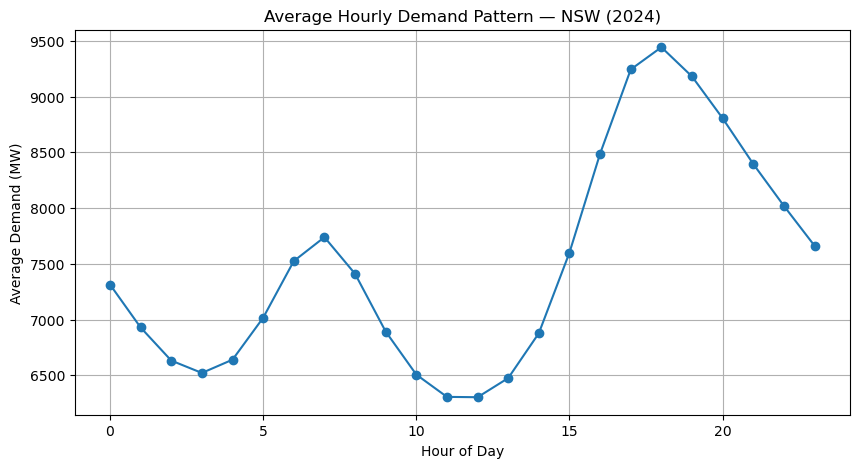

In [20]:
import matplotlib.pyplot as plt

hourly_pattern = df.groupby('hour')['TOTALDEMAND'].mean()

plt.figure(figsize=(10,5))
plt.plot(hourly_pattern.index, hourly_pattern.values, marker='o')
plt.title("Average Hourly Demand Pattern — NSW (2024)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Demand (MW)")
plt.grid(True)
plt.show()


## 📉 1. Average Hourly Demand Pattern — NSW (2024)

This analysis shows the **intraday load curve** for New South Wales (NSW). It reflects how electricity demand changes across the 24 hours of the day, primarily influenced by consumer behaviour, commercial activity, and the impact of solar generation.

---

### 🔍 Key Insights


* **Overnight Decline (12 AM – 5 AM):**
    * Demand steadily decreases from **~7,300 MW to ~6,500 MW** as residential and commercial activity is minimal.
    * This period represents the **baseload** electricity usage of the region.

* **Morning Ramp-Up (6 AM – 9 AM):**
    * A sharp increase occurs as households begin morning routines and commercial buildings start operations.
    * The morning peak reaches approximately **~7,700 MW**.

* **Midday Solar Dip (11 AM – 2 PM):**
    * Demand dips significantly (**~6,300–6,500 MW**) due to strong **rooftop solar generation** offsetting grid demand.
    * This phenomenon creates the typical **“solar belly curve”** seen in high solar-penetration regions.

* **Afternoon Recovery (2 PM – 5 PM):**
    * Solar output drops and commercial activity remains active, causing demand to rise steadily.

* **Evening Peak (5 PM – 8 PM):**
    * The **highest demand period** of the day (**~9,400–9,500 MW**).
    * This is driven primarily by residential usage as solar power is no longer available.
    * This window represents **NSW’s most critical period** for grid stability and capacity.

* **Late Night Decline (9 PM – 12 AM):**
    * Demand decreases as households wind down, stabilising again around **~7,600 MW** by midnight.

---

### 📌 Summary for Notebook

NSW displays a characteristic **dual-peak daily profile** with a moderate morning peak and a strong evening peak. A pronounced midday dip caused by rooftop solar generation forms a **“solar belly”** shape. Evening demand rises sharply as solar output declines and residential loads increase — creating significant operational challenges for the electricity grid during peak hours.

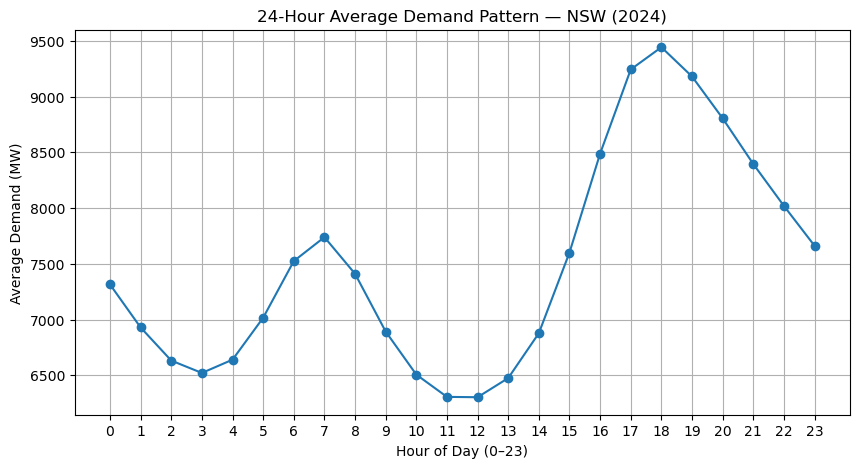

In [24]:
# 24-hour window (average hourly demand over the whole year)
daily_24h = df.groupby(df['SETTLEMENTDATE'].dt.hour)['TOTALDEMAND'].mean()

plt.figure(figsize=(10,5))
plt.plot(daily_24h.index, daily_24h.values, marker='o')
plt.title("24-Hour Average Demand Pattern — NSW (2024)")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Average Demand (MW)")
plt.xticks(range(0,24))
plt.grid(True)
plt.show()


## STEP 3 — WEEKDAY PATTERN ANALYSIS

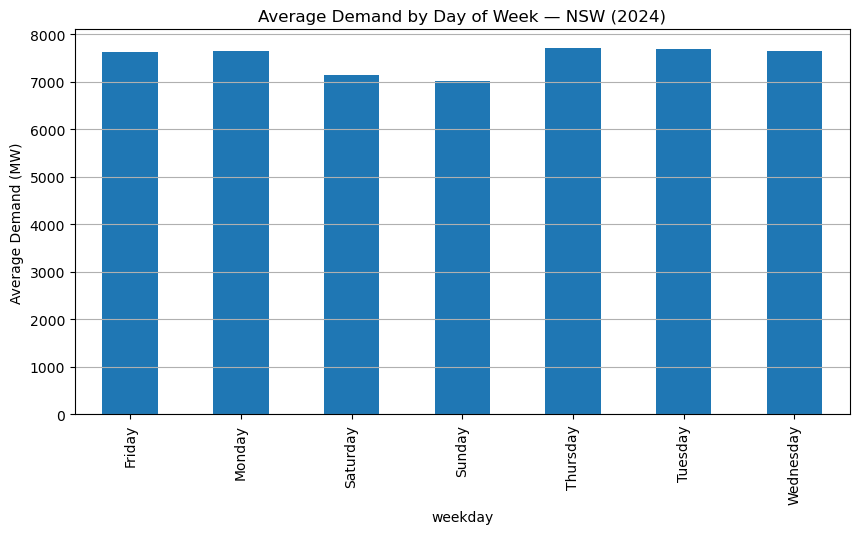

In [22]:
weekly_pattern = df.groupby('weekday')['TOTALDEMAND'].mean()

plt.figure(figsize=(10,5))
weekly_pattern.plot(kind='bar')
plt.title("Average Demand by Day of Week — NSW (2024)")
plt.ylabel("Average Demand (MW)")
plt.grid(axis='y')
plt.show()


## 🗓️ 2. Average Weekly Demand Pattern — NSW (2024)

This analysis compares electricity demand across the seven days of the week to understand the influence of **behavioural and commercial load patterns** on the grid.

---

### 🔍 Key Insights

* **Weekdays (Mon–Fri): Higher Demand (~7,600–7,800 MW)**
    * Demand is significantly higher on weekdays.
    * This is primarily driven by peak commercial buildings, industries, offices, schools, and transport-related activity.

* **Weekends (Sat–Sun): Lower Demand (~7,000–7,200 MW)**
    * Reduced business and industrial
       operations cause a noticeable drop in average demand.

* **Sunday: Lowest Demand Day**
    * Minimal industrial activity and consistently lower commercial consumption throughout the day lead to **Sunday** being the lowest average demand day in the week.

* **Friday Slight Dip:**
    * A slight reduction in demand is often observed on Friday afternoons/evenings as some industries and offices begin reducing load earlier, especially noticeable in months with moderate weather.

---

### 📌 Summary for Notebook

The weekly profile clearly shows **higher electricity demand on weekdays** due to the concentration of commercial and industrial activity. Demand drops sharply on weekends, with **Sunday being the lowest**. This pattern reflects the strong influence of business operations on NSW’s overall electricity load profile.

## Phase 4 

### STEP 1 — SEASONAL PATTERN ANALYSIS

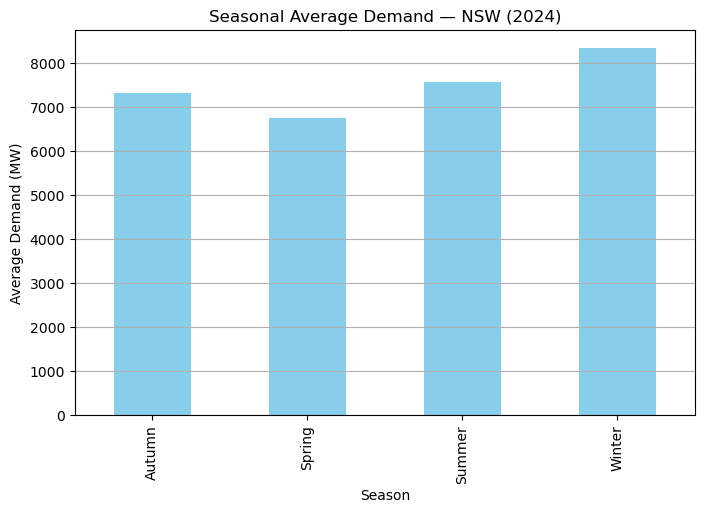

In [25]:
seasonal_avg = df.groupby('season_name')['TOTALDEMAND'].mean()

plt.figure(figsize=(8,5))
seasonal_avg.plot(kind='bar', color='skyblue')
plt.title("Seasonal Average Demand — NSW (2024)")
plt.ylabel("Average Demand (MW)")
plt.xlabel("Season")
plt.grid(axis='y')
plt.show()


### STEP 2 — TREND ANALYSIS (Rolling Averages)

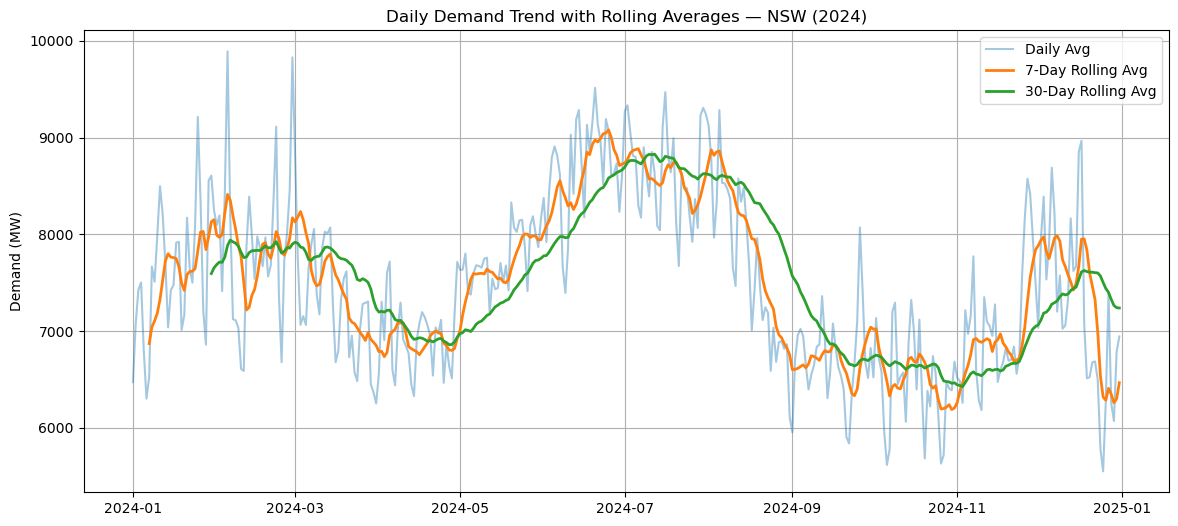

In [26]:
df_trend = df.set_index('SETTLEMENTDATE').resample('D')['TOTALDEMAND'].mean()

plt.figure(figsize=(14,6))
plt.plot(df_trend, label='Daily Avg', alpha=0.4)
plt.plot(df_trend.rolling(7).mean(), label='7-Day Rolling Avg', linewidth=2)
plt.plot(df_trend.rolling(30).mean(), label='30-Day Rolling Avg', linewidth=2)
plt.title("Daily Demand Trend with Rolling Averages — NSW (2024)")
plt.ylabel("Demand (MW)")
plt.legend()
plt.grid(True)
plt.show()


## 📈 Daily Demand Trend & Rolling Averages — NSW (2024)

The rolling-average trend analysis helps reveal the true underlying demand behaviour by smoothing out short-term volatility caused by weather, rooftop solar fluctuations, or sudden industrial load variations.

#### 🔍 Key Insights
#### 1️⃣ Daily Average Demand (Blue Line)

- Shows strong volatility, especially during summer (Jan–Feb) and winter (Jul–Aug).

- Sharp spikes correspond to heatwaves and cold snaps, when HVAC load increases significantly.

- Daily troughs represent mild weather days and high rooftop PV contribution.

#### 2️⃣ 7-Day Rolling Average (Orange Line)

- Smooths weekly noise to show broader patterns.

#### Highlights:

- Peak summer demand in late January–early February.

- Sharp decline in April as temperatures moderate.

- Strong winter rise peaking in July–August.

- Spring moderation with milder temperatures and strong solar generation.

#### 3️⃣ 30-Day Rolling Average (Green Line)

- Shows seasonal structure clearly:

- Summer highs (Jan–Feb): ~7800–8800 MW

- Autumn dip (Apr–May): ~6800–7200 MW

- Winter peak (Jul–Aug): ~8300–9000 MW

- Spring decline (Sep–Oct): ~6600–7200 MW

Early summer rise (Nov–Dec)

### ⭐ Why This Matters

- Rolling averages help system operators and planners identify:

- Seasonal demand behaviour

- Climate-driven demand shifts

- Baseline load without short-term spikes

### Forms a strong foundation for:

- Forecasting

- Operational planning

- Network capacity management

### STEP 3 — HEATMAP (Hour × Month)

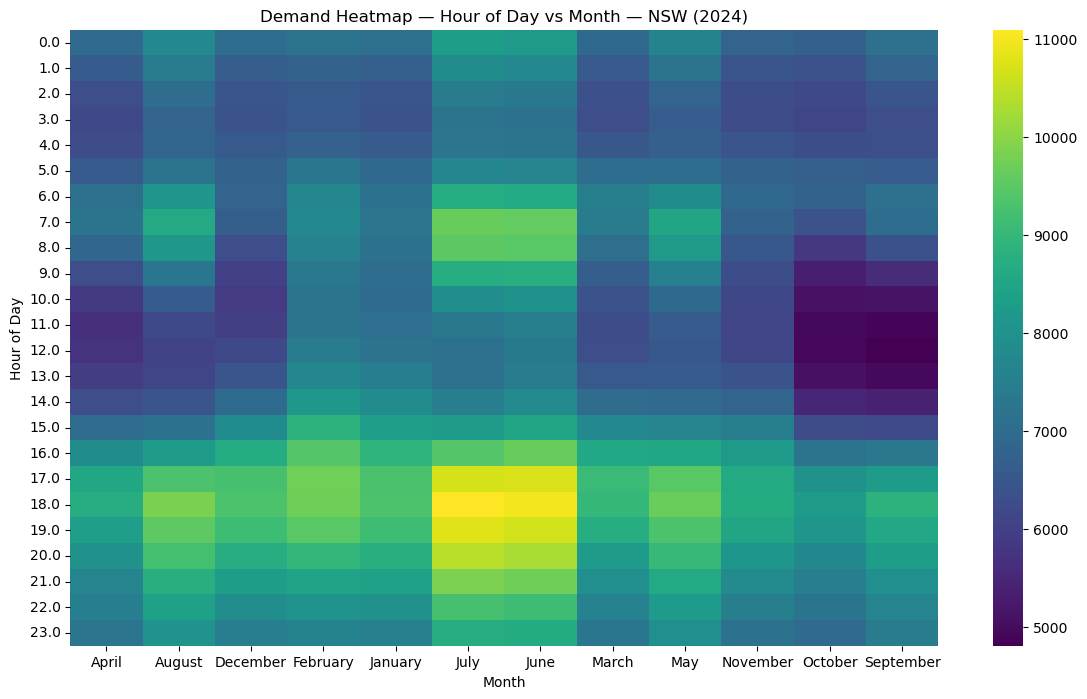

In [27]:
import seaborn as sns

heatmap_df = df.pivot_table(
    index=df['hour'],
    columns=df['month_name'],
    values='TOTALDEMAND',
    aggfunc='mean'
)

plt.figure(figsize=(14,8))
sns.heatmap(heatmap_df, cmap='viridis')
plt.title("Demand Heatmap — Hour of Day vs Month — NSW (2024)")
plt.xlabel("Month")
plt.ylabel("Hour of Day")
plt.show()


## 🔥 3. Demand Heatmap: Hour of Day × Month — NSW (2024)

This heatmap visualises how electricity demand varies jointly by **time of day and month of year** — giving a critical 2D view of combined seasonality and daily cycles.



---

### 🔍 Key Insights From the Heatmap

1.  **Morning Peaks (~6 AM – 9 AM):**
    * The morning peak is **consistent across all months**.
    * It is **Strongest in winter (June–August)**, driven by high heating demand and lighting needs before sunrise.
    * It is **Moderate in summer** due to early solar generation beginning to offset grid demand.

2.  **Evening Peaks (~4 PM – 8 PM):**
    * This window contains the **highest demand of the entire year** (the darkest areas on the map).
    * **Most Extreme in:**
        * **Summer (Dec–Feb):** High **air-conditioning load** after solar power drops off.
        * **Winter (Jul–Aug):** High **heating and lighting load** after sunset.

3.  **Midday Dip (~10 AM – 2 PM):**
    * Demand decreases significantly in these hours, creating the "solar belly."
    * This is primarily due to **strong rooftop solar production** and mild mid-morning weather conditions.
    * **Most Visible in:** Spring, Summer, and early Autumn when solar resources are highest.

4.  **Seasonal Demand Shifts:**
    * **Summer:** Characterised by high morning and high evening peaks due to temperature extremes.
    * **Autumn:** Shows a more balanced profile with softer, less extreme peaks.
    * **Winter:** Exhibits strong, elevated morning and evening peaks, heavily **heating-driven**.
    * **Spring:** Represents the **lowest overall demand** due to mild temperatures combined with strong solar generation.

---



The heatmap clearly shows NSW’s **dual-peak daily demand structure**, with both the morning and evening peaks being strongly intensified during the **summer and winter months**. The midday dips highlight the significant and growing influence of solar generation. This **Hour × Month** pattern is critical for understanding operational constraints, managing peak capacity, and accurately planning forecasting models.